## 1. Library Imports

In [3]:
# General libraries
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

# Path handling
from pathlib import Path

# Torch libraries
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

#### Check if CUDA (GPU) is available

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Dataset Structure and Path Setup

We are using the LC25000 dataset which contains histopathological images categorized into:

- Lung benign tissue
- Lung adenocarcinoma
- Lung squamous cell carcinoma
- Colon adenocarcinoma
- Colon benign tissue

Each category has 5,000 images (total: 25,000 images).


In [5]:
# Set root path
BASE_PATH = Path("lung_colon_image_set")
colon_path = BASE_PATH / "colon_image_sets"
lung_path = BASE_PATH / "lung_image_sets"

# Dictionary of class folders with corresponding (tissue_type, tumor_type)
CLASS_MAP = {
    colon_path / "colon_aca":    ("colon", "adenocarcinoma"),
    colon_path / "colon_n":      ("colon", "benign"),
    lung_path / "lung_aca":      ("lung", "adenocarcinoma"),
    lung_path / "lung_n":        ("lung", "benign"),
    lung_path / "lung_scc":      ("lung", "squamous"),
}

#### Data Summary and Exploration


In [6]:
# Collect metadata
image_paths = []
tissue_labels = []
tumor_labels = []

for folder, (tissue, tumor) in CLASS_MAP.items():
    files = list(folder.glob("*.jpeg"))
    for f in files:
        image_paths.append(str(f))
        tissue_labels.append(tissue)
        tumor_labels.append(tumor)

# Create a DataFrame
df = pd.DataFrame({
    "image_path": image_paths,
    "tissue_type": tissue_labels,
    "tumor_type": tumor_labels
})

df.head()

,image_path,tissue_type,tumor_type
0,lung_colon_image_set\colon_image_sets\colon_ac...,colon,adenocarcinoma
1,lung_colon_image_set\colon_image_sets\colon_ac...,colon,adenocarcinoma
2,lung_colon_image_set\colon_image_sets\colon_ac...,colon,adenocarcinoma
3,lung_colon_image_set\colon_image_sets\colon_ac...,colon,adenocarcinoma
4,lung_colon_image_set\colon_image_sets\colon_ac...,colon,adenocarcinoma


#### Class Distribution

C:\Users\burakdogan\AppData\Local\Temp\ipykernel_8448\423332531.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="tissue_type", palette="Set2")


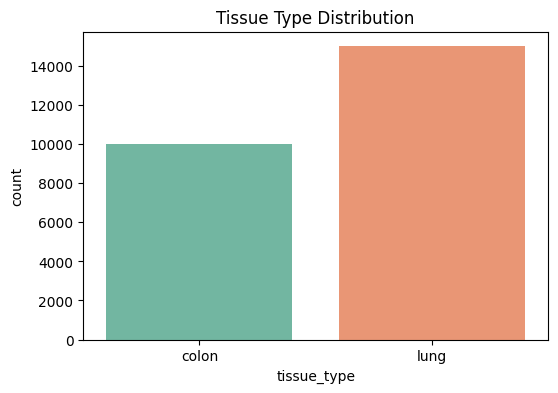

C:\Users\burakdogan\AppData\Local\Temp\ipykernel_8448\423332531.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="tumor_type", palette="Set3")


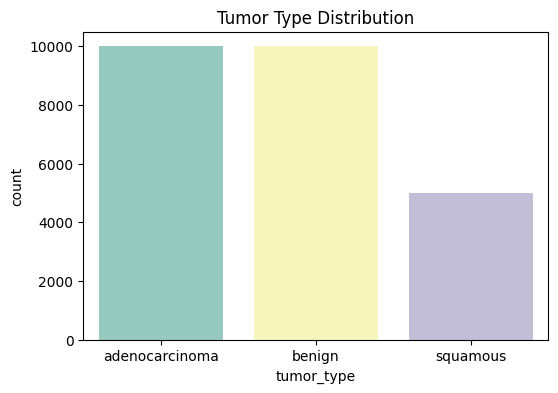

In [7]:
# Tissue class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="tissue_type", palette="Set2")
plt.title("Tissue Type Distribution")
plt.show()

# Tumor type distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="tumor_type", palette="Set3")
plt.title("Tumor Type Distribution")
plt.show()


#### Visualizing Random Samples from Each Class

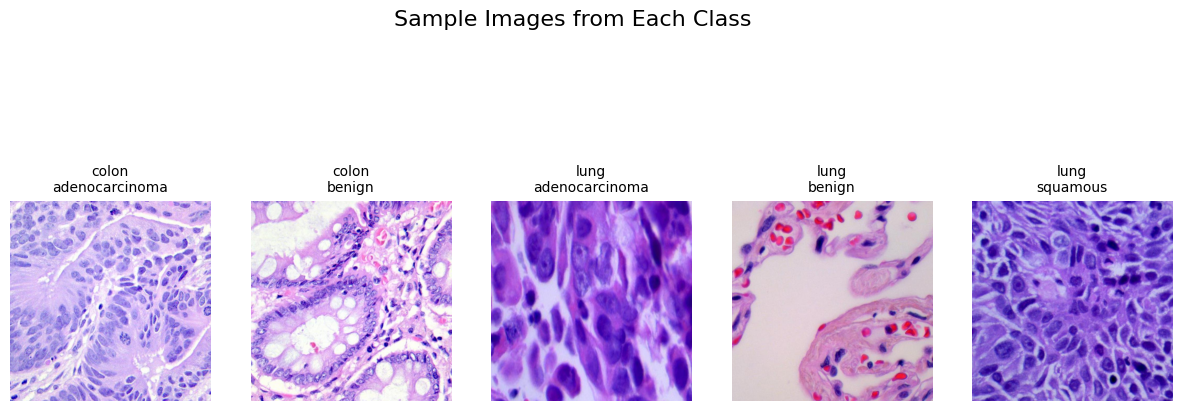

In [8]:
plt.figure(figsize=(15, 6))
for idx, (folder, (tissue, tumor)) in enumerate(CLASS_MAP.items()):
    sample_path = random.choice(list((folder).glob("*.jpeg")))
    img = Image.open(sample_path)
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(f"{tissue}\n{tumor}", fontsize=10)
    plt.axis("off")
plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.show()

## 3. Data Preprocessing & Transformations

The original image size is 768x768 pixels, which is large and computationally expensive to process. We will resize images to a more manageable size (e.g., 224x224), which is also compatible with common pretrained models like ResNet.

We'll also normalize the images using the ImageNet mean and standard deviation values:
- Mean = [0.485, 0.456, 0.406]
- Std  = [0.229, 0.224, 0.225]


#### Define Transformations

In [9]:
# Image transformations for training and testing
image_size = 224  # Resize all images to 224x224

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

## 4. Custom PyTorch Dataset for Multi-task Learning

#### Define Label Mappings

We are doing multi-task learning, so we need to encode:
- Tissue type (`lung`, `colon`) → 0 or 1
- Tumor type (`benign`, `adenocarcinoma`, `squamous`) → 0, 1, 2

These will be our two classification targets.

In [10]:
# Encoding maps
TISSUE_LABELS = {'lung': 0, 'colon': 1}
TUMOR_LABELS = {'benign': 0, 'adenocarcinoma': 1, 'squamous': 2}


#### Define Custom Dataset Class

In [11]:
class HistopathologyMultiTaskDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        tissue_type = TISSUE_LABELS[row['tissue_type']]
        tumor_type = TUMOR_LABELS[row['tumor_type']]
        
        # Load image
        image = Image.open(image_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        # Return image and both labels as a dictionary
        labels = {
            'tissue': torch.tensor(tissue_type, dtype=torch.long),
            'tumor': torch.tensor(tumor_type, dtype=torch.long)
        }
        return image, labels


#### Sanity Check with Sample

In [12]:
# Sample usage with transformations
dataset = HistopathologyMultiTaskDataset(df, transform=train_transform)

# Check shape and label
sample_img, sample_labels = dataset[0]

print(f"Image shape: {sample_img.shape}")
print(f"Tissue label: {sample_labels['tissue']}")
print(f"Tumor label: {sample_labels['tumor']}")


Image shape: torch.Size([3, 224, 224])
Tissue label: 1
Tumor label: 1


## 5. Dataset Split (Train / Validation / Test) & PyTorch DataLoaders

#### Stratified Train / Validation / Test Split

We will split the dataset as follows:
- 80% → Training
- 10% → Validation
- 10% → Test

We'll stratify by `tumor_type` to maintain class distribution in all subsets.

In [13]:
# First, split into train (80%) and temp (20%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['tumor_type'],
    random_state=42
)

# Then split temp into validation (10%) and test (10%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['tumor_type'],
    random_state=42
)

# Sanity checks
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Train samples: 20000
Validation samples: 2500
Test samples: 2500


#### Create Dataset Objects

In [14]:
# Create Dataset objects with appropriate transforms
train_dataset = HistopathologyMultiTaskDataset(train_df, transform=train_transform)
val_dataset   = HistopathologyMultiTaskDataset(val_df, transform=test_transform)
test_dataset  = HistopathologyMultiTaskDataset(test_df, transform=test_transform)

#### Create DataLoaders

In [ ]:
# Set batch size
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 6. Model Architecture (Multi-task Learning)

#### Define the Multi-task Model

In multi-task learning, the model has a shared backbone for feature extraction and multiple heads for different tasks. Here, we have:
- **Shared CNN backbone**: Using **ResNet50** pretrained on ImageNet.
- **Two heads**: 
    - One for tissue classification (`lung`, `colon`).
    - One for tumor classification (`benign`, `adenocarcinoma`, `squamous`).

In [16]:
class MultiTaskResNet18(nn.Module):
    def __init__(self, num_tissue_classes=2, num_tumor_classes=3):
        super(MultiTaskResNet18, self).__init__()
        
        # Load a pre-trained ResNet50 model
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the fully connected layer for the shared backbone
        self.resnet.fc = nn.Identity()  # Remove original fc layer
        
        # Add task-specific heads
        self.tissue_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_tissue_classes)
        )
        
        self.tumor_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_tumor_classes)
        )
    
    def forward(self, x):
        # Extract features from the shared CNN backbone
        features = self.resnet(x)
        
        # Get tissue and tumor predictions from their respective heads
        tissue_output = self.tissue_head(features)
        tumor_output = self.tumor_head(features)
        
        return tissue_output, tumor_output


#### Model Summary

The model uses **ResNet50** as the shared feature extractor, and adds two heads for the respective classification tasks:
1. **Tissue Classification**: Determines if the image is lung or colon tissue.
2. **Tumor Classification**: Determines the type of tumor (benign, adenocarcinoma, squamous).

Here’s a breakdown of the architecture:
- ResNet50 (Pretrained) backbone: Feature extraction layer.
- Tissue head: Fully connected layers for tissue classification.
- Tumor head: Fully connected layers for tumor classification.

#### Check Model Architecture

In [17]:
# Initialize the model
model = MultiTaskResNet18()

# Print the model architecture
print(model)

MultiTaskResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

c:\Users\burakdogan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\burakdogan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 7. Loss Functions and Optimizer

#### Define Loss Functions

We will use **Cross-Entropy Loss** for both tasks:
- **Tissue Classification**: Using `nn.CrossEntropyLoss()`
- **Tumor Classification**: Using `nn.CrossEntropyLoss()`

Both will be optimized jointly, allowing the model to learn to predict both tissue type and tumor type.


In [18]:
# Define loss functions for both tasks
tissue_criterion = nn.CrossEntropyLoss()
tumor_criterion = nn.CrossEntropyLoss()

#### Set Up the Optimizer

We will use **Adam** optimizer for training the model. Adam is a good choice for deep learning as it adapts the learning rate during training.
- We will apply a learning rate of **1e-4** to start with.

In [19]:
# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#### Training and Validation Loss Calculation

During training and validation, we will calculate the losses for both tasks. For each batch:
- Tissue loss = Cross-Entropy loss for tissue classification.
- Tumor loss = Cross-Entropy loss for tumor classification.

The total loss is the sum of these two losses:
- **Total Loss** = Tissue Loss + Tumor Loss


In [20]:
def calculate_loss(tissue_output, tumor_output, tissue_labels, tumor_labels, tissue_criterion, tumor_criterion):
    tissue_loss = tissue_criterion(tissue_output, tissue_labels)  
    tumor_loss = tumor_criterion(tumor_output, tumor_labels)  
    total_loss = tissue_loss + tumor_loss
    return total_loss, tissue_loss, tumor_loss

#### Forward Pass Example

In [19]:
'''model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    sample_images, sample_labels = next(iter(train_loader))
    tissue_output, tumor_output = model(sample_images.to(device))

    # Calculate losses for this batch
    total_loss, tissue_loss, tumor_loss = calculate_loss(tissue_output, tumor_output,
                                                          sample_labels['tissue'].to(device), 
                                                          sample_labels['tumor'].to(device))

    print(f"Total Loss: {total_loss.item()}, Tissue Loss: {tissue_loss.item()}, Tumor Loss: {tumor_loss.item()}")'''


'model.eval()  # Set the model to evaluation mode\nwith torch.no_grad():\n    sample_images, sample_labels = next(iter(train_loader))\n    tissue_output, tumor_output = model(sample_images.to(device))\n\n    # Calculate losses for this batch\n    total_loss, tissue_loss, tumor_loss = calculate_loss(tissue_output, tumor_output,\n                                                          sample_labels[\'tissue\'].to(device), \n                                                          sample_labels[\'tumor\'].to(device))\n\n    print(f"Total Loss: {total_loss.item()}, Tissue Loss: {tissue_loss.item()}, Tumor Loss: {tumor_loss.item()}")'

## 8. Training Loop

#### Training and Validation Functions

The training function will:
1. Iterate through the training DataLoader.
2. Perform forward and backward passes.
3. Calculate the total loss and the losses for tissue and tumor.
4. Update the model parameters using the optimizer.

The validation function will:
1. Evaluate the model without updating the weights.
2. Calculate the validation loss for both tasks.

Both functions will track the loss for each task during training and validation.

In [ ]:
def train_one_epoch(model, train_loader, optimizer, tissue_criterion, tumor_criterion, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    tissue_preds, tumor_preds = [], []  # Lists to store predictions
    tissue_labels, tumor_labels = [], []  # Lists to store ground truth labels
    
    start_time = time.time()  # Track the start time of the epoch

    for batch_idx, sample_batch in enumerate(train_loader):  # Loop through the training data
        images, labels = sample_batch  # Unpack images and labels from the batch

        # Send images and labels to the GPU
        images, tissue_labels_batch, tumor_labels_batch = images.to(device, non_blocking=True), labels['tissue'].to(device, non_blocking=True), labels['tumor'].to(device, , non_blocking=True)

        optimizer.zero_grad()  # Zero the gradients before backpropagation

        # Get model outputs (predictions for tissue and tumor)
        tissue_output, tumor_output = model(images)

        # Calculate the total loss (sum of tissue and tumor losses)
        total_loss, tissue_loss, tumor_loss = calculate_loss(tissue_output, tumor_output, tissue_labels_batch, tumor_labels_batch, tissue_criterion, tumor_criterion)

        total_loss.backward()  # Perform backpropagation
        optimizer.step()  # Update model weights

        running_loss += total_loss.item()  # Accumulate the running loss

        # Append predictions and labels to the lists (no need to move to CPU yet)
        tissue_preds.extend(torch.argmax(tissue_output, dim=1).tolist())  # Store tissue predictions (in the form of list)
        tumor_preds.extend(torch.argmax(tumor_output, dim=1).tolist())  # Store tumor predictions (in the form of list)
        tissue_labels.extend(tissue_labels_batch.tolist())  # Store tissue ground truth labels
        tumor_labels.extend(tumor_labels_batch.tolist())  # Store tumor ground truth labels

        if batch_idx % 10 == 0:  # Print progress every 10 batches
            print(f"Batch {batch_idx}/{len(train_loader)} - Tissue Loss: {tissue_loss.item():.4f} | Tumor Loss: {tumor_loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)  # Calculate average loss over the entire training set
    train_time = time.time() - start_time  # Calculate the total training time for the epoch

    return avg_loss, tissue_preds, tumor_preds, tissue_labels, tumor_labels, train_time  # Return the results


In [22]:
def validate_one_epoch(model, val_loader, tissue_criterion, tumor_criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    tissue_preds, tumor_preds = [], []  # Lists to store predictions
    tissue_labels, tumor_labels = [], []  # Lists to store ground truth labels

    with torch.no_grad():  # Disable gradient calculation during evaluation (saves memory and computation)
        for batch_idx, sample_batch in enumerate(val_loader):  # Loop through the validation data
            images, labels = sample_batch  # Unpack images and labels from the batch

            tissue_output, tumor_output = model(images)  # Get model outputs (predictions for tissue and tumor)

            # Calculate the total loss (sum of tissue and tumor losses)
            total_loss, tissue_loss, tumor_loss = calculate_loss(tissue_output, tumor_output, tissue_labels_batch, tumor_labels_batch, tissue_criterion, tumor_criterion)

            running_loss += total_loss.item()  # Accumulate the running loss

            # Append predictions and labels to the lists (no need to move to CPU yet)
            tissue_preds.extend(torch.argmax(tissue_output, dim=1).cpu().numpy())  # Store tissue predictions
            tumor_preds.extend(torch.argmax(tumor_output, dim=1).cpu().numpy())  # Store tumor predictions
            tissue_labels.extend(tissue_labels_batch.cpu().numpy())  # Store tissue ground truth labels
            tumor_labels.extend(tumor_labels_batch.cpu().numpy())  # Store tumor ground truth labels

            if batch_idx % 10 == 0:  # Print progress every 10 batches
                print(f"Batch {batch_idx}/{len(val_loader)} - Tissue Loss: {tissue_loss.item():.4f} | Tumor Loss: {tumor_loss.item():.4f}")

    avg_loss = running_loss / len(val_loader)  # Calculate average loss over the entire validation set

    return avg_loss, tissue_preds, tumor_preds, tissue_labels, tumor_labels  # Return the results


#### Training and Validation Loop

In the loop:
1. Train the model for one epoch.
2. Validate the model after every epoch.
3. Track both training and validation losses.
4. Optionally, save the best model based on validation loss.


In [23]:
def train_model(model, train_loader, val_loader, optimizer, tissue_criterion, tumor_criterion, device, num_epochs=10):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_tissue_accuracies, val_tissue_accuracies = [], []
    train_tumor_accuracies, val_tumor_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train for one epoch
        train_loss, tissue_preds, tumor_preds, tissue_labels, tumor_labels, train_time = train_one_epoch(
            model, train_loader, optimizer, tissue_criterion, tumor_criterion, device
        )

        # Validate after each epoch
        val_loss, val_tissue_preds, val_tumor_preds, val_tissue_labels, val_tumor_labels = validate_one_epoch(
            model, val_loader, tissue_criterion, tumor_criterion, device
        )

        # Calculate accuracies
        train_tissue_accuracy = accuracy_score(tissue_labels, tissue_preds)
        val_tissue_accuracy = accuracy_score(val_tissue_labels, val_tissue_preds)
        train_tumor_accuracy = accuracy_score(tumor_labels, tumor_preds)
        val_tumor_accuracy = accuracy_score(val_tumor_labels, val_tumor_preds)

        print(f"\nEpoch {epoch+1} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Tissue Accuracy: {train_tissue_accuracy:.4f} | "
              f"Train Tumor Accuracy: {train_tumor_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Tissue Accuracy: {val_tissue_accuracy:.4f} | "
              f"Val Tumor Accuracy: {val_tumor_accuracy:.4f} | "
              f"Time: {train_time:.2f}s")

        # Save the model with the lowest validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved best model based on validation loss.")

        # Track loss and accuracy for visualization
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_tissue_accuracies.append(train_tissue_accuracy)
        val_tissue_accuracies.append(val_tissue_accuracy)
        train_tumor_accuracies.append(train_tumor_accuracy)
        val_tumor_accuracies.append(val_tumor_accuracy)

    return train_losses, val_losses, train_tissue_accuracies, val_tissue_accuracies, train_tumor_accuracies, val_tumor_accuracies


#### Training the Model

In [24]:
# Move the model to the selected device (GPU/CPU)
model.to(device)

MultiTaskResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [26]:
print(next(model.parameters()).device)  # Model GPU'da mı kontrol et

cuda:0


In [ ]:
# Train the model
train_losses, val_losses, train_tissue_accuracies, val_tissue_accuracies, train_tumor_accuracies, val_tumor_accuracies = train_model(
    model, train_loader, val_loader, optimizer, tissue_criterion, tumor_criterion, device, num_epochs=10
)


Epoch 1/10


#### 9. Model Testing

#### Define the Test Function

We will evaluate the model using:
- **Accuracy** for tissue classification (lung vs. colon).
- **Accuracy** for tumor classification (benign, adenocarcinoma, squamous).


In [ ]:
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    tissue_preds, tumor_preds = [], []
    tissue_labels, tumor_labels = [], []

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_idx, sample_batch in enumerate(test_loader):
            images, labels = sample_batch
            images, tissue_label, tumor_label = images.to(device), labels['tissue'].to(device), labels['tumor'].to(device)

            tissue_output, tumor_output = model(images)  # Forward pass
            tissue_preds.extend(torch.argmax(tissue_output, dim=1).cpu().numpy())  # Tissue predictions
            tumor_preds.extend(torch.argmax(tumor_output, dim=1).cpu().numpy())  # Tumor predictions

            tissue_labels.extend(tissue_label.cpu().numpy())  # True tissue labels
            tumor_labels.extend(tumor_label.cpu().numpy())  # True tumor labels

    # Calculate accuracies
    tissue_accuracy = accuracy_score(tissue_labels, tissue_preds)
    tumor_accuracy = accuracy_score(tumor_labels, tumor_preds)

    print(f"Test Tissue Classification Accuracy: {tissue_accuracy:.4f}")
    print(f"Test Tumor Classification Accuracy: {tumor_accuracy:.4f}")

    # Generate classification reports
    tissue_report = classification_report(tissue_labels, tissue_preds, target_names=['lung', 'colon'], output_dict=True)
    tumor_report = classification_report(tumor_labels, tumor_preds, target_names=['benign', 'adenocarcinoma', 'squamous'], output_dict=True)

    print("Tissue Classification Report:\n", tissue_report)
    print("Tumor Classification Report:\n", tumor_report)

    # Return the labels and predictions for later visualization
    return tissue_labels, tissue_preds, tumor_labels, tumor_preds

In [ ]:
def plot_confusion_matrices(tissue_labels, tissue_preds, tumor_labels, tumor_preds):
    # Confusion matrices for tissue and tumor classification
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.heatmap(confusion_matrix(tissue_labels, tissue_preds), annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title("Tissue Classification Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    axes[0].set_xticklabels(['lung', 'colon'])
    axes[0].set_yticklabels(['lung', 'colon'])

    sns.heatmap(confusion_matrix(tumor_labels, tumor_preds), annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title("Tumor Classification Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    axes[1].set_xticklabels(['benign', 'adenocarcinoma', 'squamous'], rotation=45)
    axes[1].set_yticklabels(['benign', 'adenocarcinoma', 'squamous'], rotation=45)

    plt.tight_layout()
    plt.show()


#### Test the Model

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Modelin test edilmesi
tissue_labels, tissue_preds, tumor_labels, tumor_preds = test_model(model, test_loader, device)

# Karışıklık matrislerini görselleştirme
plot_confusion_matrices(tissue_labels, tissue_preds, tumor_labels, tumor_preds)

#### Plotting function for overfitting detection and visualization

In [ ]:
def plot_metrics(train_losses, val_losses, train_tissue_accuracies, val_tissue_accuracies, train_tumor_accuracies, val_tumor_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy Plot for Tissue
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_tissue_accuracies, label='Train Tissue Accuracy', color='blue')
    plt.plot(epochs, val_tissue_accuracies, label='Validation Tissue Accuracy', color='red')
    plt.title('Tissue Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy Plot for Tumor
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_tumor_accuracies, label='Train Tumor Accuracy', color='green')
    plt.plot(epochs, val_tumor_accuracies, label='Validation Tumor Accuracy', color='orange')
    plt.title('Tumor Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_metrics(train_losses, val_losses, train_tissue_accuracies, val_tissue_accuracies, train_tumor_accuracies, val_tumor_accuracies)